# Classifying MNIST Digits using an Multi-Layer Perceptron

### First we organize out imports of libraries and functions we will need to use.

In [1]:
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Load the MNIST Dataset using Tensorflow's built in data loader. 

In [2]:
# Download and parse the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Transform the images from the range [0..255] uint8 to [0..1] float32
x_train = tf.expand_dims(x_train.astype(np.float32) / 255.0, axis=-1) # [60000, 28, 28, 1]
x_test  = tf.expand_dims( x_test.astype(np.float32) / 255.0, axis=-1) # [10000, 28, 28, 1]

# Dimensions of image data is [num_images, height, width, channel]
# Dimensions of label data is [num_images,] and is a list of integers

### A function for plotting some randomly selected images along with their true and model predicted labels. 

In [3]:
def plot_test_images(model, images, labels):
    # Plot a series of images from the test set with their true and predicted labels
    plt.figure(figsize=(12,2), dpi=80)    
    num_images_to_show = 8
    for col, idx in enumerate(np.random.choice(images.shape[0], num_images_to_show)):
        plt.subplot(1, num_images_to_show, col + 1)
        plt.axis('off')

        # Perform inference on a single image, need to put it in a batch with batch size 1
        batch = np.expand_dims(images[idx], axis=0) # batch has size [1, 28, 28, 1]
        probs = model.predict(batch)                # probs has size [1, 10]
        pred_class = np.argmax(probs[0])            # predicted class is an integer

        # x_train is a 4-dimensional array, we want to slice out a single 28x28 pixel image
        plt.imshow(images[idx,:,:,0])
        plt.title('True: %d\nPred: %d' % (labels[idx], pred_class))
    plt.show()

### A function for building a model which will default to being randomly initialized.

Model is a simple Multi-Layer Perceptron. 
- It takes as input a 28x28 image (784 pixels) and flattens this representation to a 1D vector of length 784. 
- A dense layer is applied to the 784 values, outputting 512 values yielding the hidden representation of the model. 
    - ReLU activation helps the model learn a more interesting strategy.
- Dropout regularization is applied which during training time will multiply a random 20% of the 512 activations by 0 each training step to disable them.
    - Dropout will help prevent overfitting by only allowing a random sub-model to be optimized each train step.
- A final dense layer from 512 values, outputting 10 values, one for each class we want to predict. 
    - Softmax activation treats these 10 class choices as a probability distribution.

In [4]:
def build_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    return model

---
# Training using the Keras Fit API

When training with simple data and loss functions it is often sufficient to use the simple Keras fit API. The API can accept tensors of data directly (amoung many other input formats) we hand the datasets off to Keras directly and let it handle looping and batching. On my machine with a GTX 1070 GPU this took 25 seconds to train 5 epochs and reached 98% test accuracy.  

In [5]:
model = build_model()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time()

model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32, epochs=5)

end_time = time()
print('total_time:', (end_time - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 89us/sample - loss: 0.2211 - accuracy: 0.9344 - val_loss: 0.1041 - val_accuracy: 0.9702
Epoch 2/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0971 - accuracy: 0.9700 - val_loss: 0.0999 - val_accuracy: 0.9695
Epoch 3/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0704 - accuracy: 0.9779 - val_loss: 0.0665 - val_accuracy: 0.9787
Epoch 4/5
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0546 - accuracy: 0.9822 - val_loss: 0.0739 - val_accuracy: 0.9771
Epoch 5/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.0610 - val_accuracy: 0.9812
total_time: 25.46125841140747


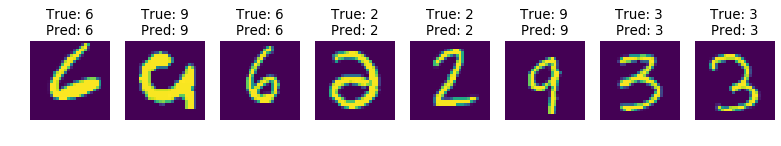

In [6]:
plot_test_images(model, x_test, y_test)

---
# Training using Eager Execution and a Gradient Tape

In advanced cases such as when using exotic loss functions or when using custom training procedures the Keras fit API may become clunky or cumbersome to achieve your goal with. In these cases you can implement your own custom train loops and update rules. 

**Note:** As soon as you do this you become responsible for a lot things, even if you would like to do most things the same as Keras fit API would do, you are now responsible for managing nearly all of it.

Let's reimplement the above code to perform the same training scheme and logging the same metrics for performance without using the Keras fit API directly. 

Specifically this time let's make use of Eager Execution which means that for each line of code running maths against our model will be executed directly when the line is reached. This allows for easy debugging because we can always add a print statement in between two lines of code and see what values are there. However, Eager execution has some overheads which can make this code execute slower than the Keras fit API which would execute our model in Graph mode. **In the next example we will show the code changes to make the model train and execute in Graph mode.**

On my machine with a GTX 1070 GPU this took 87 seconds to train 5 epochs and also reached 98% test accuracy. While the model still reaches the same accuracy it is significantly slower due to the Eager execution of the gradient computation and weight update.

In [7]:
model = build_model()

batch_size = 32
num_epochs = 5

# Define an optimizer with default parameters and instance a loss function
optimizer      = tf.keras.optimizers.Adam()
loss_function  = tf.keras.losses.SparseCategoricalCrossentropy()

# Metrics for logging prediction average accuracy and loss per epoch
train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
train_loss_metric     = tf.keras.metrics.Mean()
test_accuracy_metric  = tf.keras.metrics.SparseCategoricalAccuracy()
test_loss_metric      = tf.keras.metrics.Mean()

# How many images and batches do we have to consider each epoch
num_train_images          = x_train.shape[0]
num_train_steps_per_epoch = num_train_images // batch_size
num_test_images           =  x_test.shape[0]
num_test_steps_per_epoch  =  num_test_images // batch_size

# We have our dataset as a pair of in RAM tensors, but we need to loop over 
# it in random minibatches. Build two dataset pipelines for shuffling and batching the data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = iter(train_dataset.shuffle(num_train_images).repeat().batch(batch_size, drop_remainder=True))
        
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset  = iter(test_dataset.shuffle(num_test_images).repeat().batch(batch_size, drop_remainder=True))

start_time = time()

for epoch in range(num_epochs):
    
    epoch_train_start_time = time()
    
    # Perform one epoch of training steps
    for step in range(num_train_steps_per_epoch):

        # Sample a random batch of images and their labels from the train set
        batch_images, batch_labels = next(train_dataset)
        
        # The gradient tape captures information during a request forwards operation so 
        # that gradients can be back calculated afterwards
        with tf.GradientTape() as tape:

            # Perform inference on this train batch allowing the gradient tape 
            # to capture information for optimizing the weights
            # Our model includes Dropout regularization so it is vital we pass training=True
            # to make sure it applies the dropout during the gradient update
            batch_preds = model(batch_images, training=True)
            train_loss  = loss_function(batch_labels, batch_preds)

        # Use the gradient tape to compute the weight derivatives and pass them to the optimizer
        grads = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Update our performance metrics for this train batch
        train_accuracy_metric.update_state(batch_labels, batch_preds)
        train_loss_metric.update_state(train_loss)
     
    epoch_train_end_time = epoch_test_start_time = time()
    
    # Perform end-of-epoch evaluation pass on test set
    for step in range(num_test_steps_per_epoch):
        
        # Sample a random batch of images and their labels from the test set
        batch_images, batch_labels = next(test_dataset)
        
        # Perform inference on this test batch
        batch_preds = model(batch_images)
        test_loss = loss_function(batch_labels, batch_preds)
        
        # Update our performance metrics for this test batch
        test_accuracy_metric.update_state(batch_labels, batch_preds)
        test_loss_metric.update_state(test_loss)
        
    epoch_test_end_time = time()
    
    # Print a summary of model performance at the end of this epoch
    print('epoch:', epoch, 'train_loss: %0.05f' %     train_loss_metric.result().numpy(), 
                            'train_acc: %0.05f' % train_accuracy_metric.result().numpy(), 
                     'epoch_train_time: %0.05f' % (epoch_train_end_time - epoch_train_start_time), 
                            'test_loss: %0.05f' %      test_loss_metric.result().numpy(),  
                             'test_acc: %0.05f' %  test_accuracy_metric.result().numpy(),  
                      'epoch_test_time: %0.05f' % ( epoch_test_end_time -  epoch_test_start_time))
    
    # Reset our performance metrics for the next epoch
    train_accuracy_metric.reset_states()
    test_accuracy_metric.reset_states()
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()
    
end_time = time()
print('total_time:', (end_time - start_time))

epoch: 0 train_loss: 0.21881 train_acc: 0.93543 epoch_train_time: 20.60076 test_loss: 0.10725 test_acc: 0.96815 epoch_test_time: 1.41453
epoch: 1 train_loss: 0.09480 train_acc: 0.97130 epoch_train_time: 19.76484 test_loss: 0.08377 test_acc: 0.97266 epoch_test_time: 1.34249
epoch: 2 train_loss: 0.06872 train_acc: 0.97933 epoch_train_time: 20.06995 test_loss: 0.06912 test_acc: 0.97746 epoch_test_time: 1.31633
epoch: 3 train_loss: 0.05300 train_acc: 0.98297 epoch_train_time: 19.94997 test_loss: 0.06857 test_acc: 0.97967 epoch_test_time: 1.37994
epoch: 4 train_loss: 0.04177 train_acc: 0.98647 epoch_train_time: 20.03919 test_loss: 0.07087 test_acc: 0.97796 epoch_test_time: 1.35345
total_time: 107.2414562702179


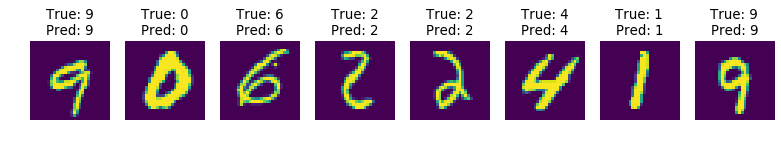

In [8]:
plot_test_images(model, x_test, y_test)

---
# Training using Graph Execution

This time let's make use of Graph Execution which means that regions of our code can be executed efficiently as a single pass using our hardware acceleration. We do this by using the ` @tf.function ` decorator to mark a Python function to be compiled as an Auto-Graph function. 

**Note:** Compared to the Eager execution example shown before this code takes the body of the train and test step loops and breaks them out into decorated Auto-Graph functions. 

On my machine with a GTX 1070 GPU this took 11 seconds to train 5 epochs and also reached 98% test accuracy. Graph execution is considerably faster than Eager execution and in this case is also faster than the Keras fit API's use of graph execution. This is likely because this is a small model which is fast to train, and the Keras fit API writes considerably more to the console to print the progress bars, adding IO overhead to the training procedure. 

In [9]:
model = build_model()

batch_size = 32
num_epochs = 5

# Define an optimizer with default parameters and instance a loss function
optimizer      = tf.keras.optimizers.Adam()
loss_function  = tf.keras.losses.SparseCategoricalCrossentropy()

# Metrics for logging prediction average accuracy and loss per epoch
train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
train_loss_metric     = tf.keras.metrics.Mean()
test_accuracy_metric  = tf.keras.metrics.SparseCategoricalAccuracy()
test_loss_metric      = tf.keras.metrics.Mean()

# How many images and batches do we have to consider each epoch
num_train_images          = x_train.shape[0]
num_train_steps_per_epoch = num_train_images // batch_size
num_test_images           =  x_test.shape[0]
num_test_steps_per_epoch  =  num_test_images // batch_size

# We have our dataset as a pair of in RAM tensors, but we need to loop over 
# it in random minibatches. Build two dataset pipelines for shuffling and batching the data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = iter(train_dataset.shuffle(num_train_images).repeat().batch(batch_size, drop_remainder=True))
        
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset  = iter(test_dataset.shuffle(num_test_images).repeat().batch(batch_size, drop_remainder=True))

# Create an auto-graph function which will efficiently perform one training step
# and also update our train metrics. In this case all the necessary variables are
# captured from global scope, we could also pass them in as parameters if needed.
@tf.function
def train_step():
    # Sample a random batch of images and their labels from the train set
    batch_images, batch_labels = next(train_dataset)
    
    # Perform inference on this train batch
    # Our model includes Dropout regularization so it is vital we pass training=True
    # to make sure it applies the dropout during the gradient update
    batch_preds = model(batch_images, training=True) 
    loss = loss_function(batch_labels, batch_preds)
    
    # Because we are in graph mode we can use tf.gradients instead of
    # making a gradient tape. This is more efficient.
    grads = tf.gradients(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Update our performance metrics for this train batch
    train_accuracy_metric.update_state(batch_labels, batch_preds)
    train_loss_metric.update_state(loss)

# Create an auto-graph function which will efficiently perform one evaluation step
# and also update our test metrics. In this case all the necessary variables are
# captured from global scope, we could also pass them in as parameters if needed.
@tf.function
def eval_step():
    # Sample a random batch of images and their labels from the test set
    batch_images, batch_labels = next(test_dataset)
    
    # Perform inference on this test batch
    batch_preds = model(batch_images)
    loss = loss_function(batch_labels, batch_preds)
    
    # Update our performance metrics for this test batch
    test_accuracy_metric.update_state(batch_labels, batch_preds)
    test_loss_metric.update_state(loss)
    
start_time = time()

for epoch in range(num_epochs):
    
    epoch_train_start_time = time()
    
    # Perform one epoch of training steps
    for step in range(num_train_steps_per_epoch): train_step()
     
    epoch_train_end_time = epoch_test_start_time = time()
    
    # Perform end-of-epoch evaluation pass on test set
    for step in range(num_test_steps_per_epoch):  eval_step()
        
    epoch_test_end_time = time()
    
    # Print a summary of model performance at the end of this epoch
    print('epoch:', epoch, 'train_loss: %0.05f' %     train_loss_metric.result().numpy(), 
                            'train_acc: %0.05f' % train_accuracy_metric.result().numpy(), 
                     'epoch_train_time: %0.05f' % (epoch_train_end_time - epoch_train_start_time), 
                            'test_loss: %0.05f' %      test_loss_metric.result().numpy(),  
                             'test_acc: %0.05f' %  test_accuracy_metric.result().numpy(),  
                      'epoch_test_time: %0.05f' % ( epoch_test_end_time -  epoch_test_start_time))
    
    # Reset our performance metrics for the next epoch
    train_accuracy_metric.reset_states()
    test_accuracy_metric.reset_states()
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()
    
end_time = time()
print('total_time:', (end_time - start_time))

epoch: 0 train_loss: 0.22197 train_acc: 0.93437 epoch_train_time: 2.88805 test_loss: 0.11108 test_acc: 0.96635 epoch_test_time: 0.31763
epoch: 1 train_loss: 0.09706 train_acc: 0.97055 epoch_train_time: 2.06033 test_loss: 0.07321 test_acc: 0.97726 epoch_test_time: 0.16764
epoch: 2 train_loss: 0.06825 train_acc: 0.97860 epoch_train_time: 2.15299 test_loss: 0.07238 test_acc: 0.97766 epoch_test_time: 0.17390
epoch: 3 train_loss: 0.05369 train_acc: 0.98305 epoch_train_time: 2.10531 test_loss: 0.06541 test_acc: 0.98027 epoch_test_time: 0.18244
epoch: 4 train_loss: 0.04327 train_acc: 0.98522 epoch_train_time: 2.16974 test_loss: 0.06007 test_acc: 0.98197 epoch_test_time: 0.19792
total_time: 12.43458104133606


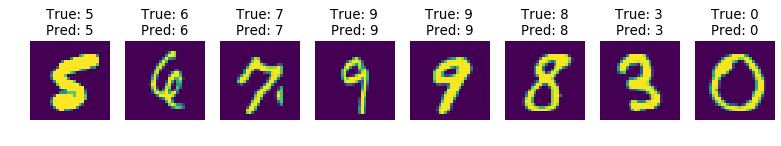

In [10]:
plot_test_images(model, x_test, y_test)